#**Proyecto - Sistemas Recomendadores - IIC3633**

## Implementación de Dwell Time en GRU4REC


Preliminar: Configuración entorno GPUs, Google Drive, entre otros.

In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd

In [2]:
# load RSC15 preprocessed train dataframe
PATH_TO_TRAIN = '../processedData/rsc15_train_tr.txt'
train_data = pd.read_csv(PATH_TO_TRAIN, sep='\t', dtype={'ItemId':np.int64})

In [3]:
def preprocess_df(df):    
    
    n_items = len(train_data['ItemId'].unique())
    aux = list(train_data['ItemId'].unique())
    itemids = np.array(aux)
    itemidmap = pd.Series(data=np.arange(n_items), index=itemids)  # (id_item => (0, n_items))
    
    item_key = 'ItemId'
    session_key = 'SessionId'
    time_key = 'Time'
    
    data = pd.merge(df, pd.DataFrame({item_key:itemids, 'ItemIdx':itemidmap[itemids].values}), on=item_key, how='inner')
    data.sort_values([session_key, time_key], inplace=True)

    length = len(data['ItemId'])
        
    return data
    
    
new_df = preprocess_df(train_data)

In [4]:
def compute_dwell_time(df):
   
    times_t = np.roll(df['Time'], -1) # Take time row
    times_dt  = df['Time']            # Copy, then displace by one
    
    diffs = np.subtract(times_t, times_dt) # Take the pairwise difference
    
    length = len(df['ItemId'])
    
    # cummulative offset start for each session
    offset_sessions = np.zeros(df['SessionId'].nunique()+1, dtype=np.int32)
    offset_sessions[1:] = df.groupby('SessionId').size().cumsum() 
    
    offset_sessions = offset_sessions - 1
    offset_sessions = np.roll(offset_sessions, -1)
    
    # session transition implies zero-dwell-time
    # note: paper statistics do not consider null entries, 
    # though they are still checked when augmenting
    np.put(diffs, offset_sessions, np.zeros((offset_sessions.shape)), mode='raise')
        
    return diffs

dts = compute_dwell_time(new_df)

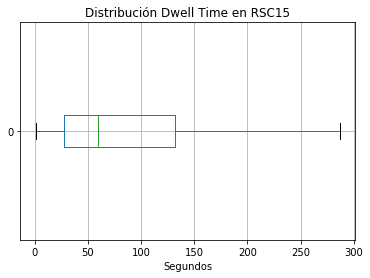

In [8]:
# get paper statistics
def get_statistics(dts):
    filtered = np.array(list(filter(lambda x: int(x) != 0, dts)))
    pd_dts = pd.DataFrame(filtered)
    pd_dts.boxplot(vert=False, showfliers=False) # no outliers in boxplot
    plt.xlabel("Segundos")
    plt.title("Distribución Dwell Time en RSC15")
    plt.savefig("./DwellTime.pdf", format="pdf")#show()
    pd_dts.describe()
    
get_statistics(dts)

In [6]:
def join_dwell_reps(df, dt, threshold=75):
    # Calculate d_ti/threshold + 1
    # then add column to dataFrame
    
    dt //= threshold
    dt += 1   
    df['DwellReps'] = pd.Series(dt.astype(np.int64), index=dt.index)
    #return df

join_dwell_reps(new_df, dts)


In [7]:
new_df.head(10)

,SessionId,ItemId,Time,ItemIdx,DwellReps
0,1,214536502,1.396879e+09,0,3
1770,1,214536500,1.396879e+09,1,1
2312,1,214536506,1.396879e+09,2,2
2381,1,214577561,1.396879e+09,3,1
2519,2,214662742,1.396890e+09,4,1
2520,2,214662742,1.396890e+09,4,2
6328,2,214825110,1.396890e+09,5,1
6803,2,214757390,1.396890e+09,6,1
7752,2,214757407,1.396890e+09,7,2
8119,2,214551617,1.396890e+09,8,1


In [8]:
# Now, we augment the sessions copying each entry an 
# additional (dwellReps[i]-1) times

def augment_old(df):
    col_names = list(df.columns.values)
    augmented  = pd.DataFrame(columns = col_names)
    
    pbar = tqdm(total=len(df['SessionId'].unique()))
    
    for row in df.iterrows():
        for rep in range(int(row[1]['DwellReps'])):
            augmented = augmented.append(row[1])#Df, ignore_index=True)
        pbar.update(1)
        
    pbar.close()
            
    return augmented

def augment(df):    
    col_names = list(df.columns.values)[:3]
    print(col_names)
    augmented = np.repeat(df.values, df['DwellReps'], axis=0) 
    print(augmented[0][:3])  
    augmented = pd.DataFrame(data=augmented[:,:3],
                             columns=col_names)
    
    dtype = {'SessionId': np.int64, 
             'ItemId': np.int64, 
             'Time': np.float32}
    
    for k, v in dtype.items():
        augmented[k] = augmented[k].astype(v)
                             
    
    return augmented

df_aug = augment(new_df)
        
print(df_aug.shape)

['SessionId', 'ItemId', 'Time']
[1.00000000e+00 2.14536502e+08 1.39687867e+09]
(68052530, 3)


In [9]:
print(df_aug.shape)
print(df_aug[:20])

(68052530, 3)
    SessionId     ItemId          Time
0           1  214536502  1.396879e+09
1           1  214536502  1.396879e+09
2           1  214536502  1.396879e+09
3           1  214536500  1.396879e+09
4           1  214536506  1.396879e+09
5           1  214536506  1.396879e+09
6           1  214577561  1.396879e+09
7           2  214662742  1.396890e+09
8           2  214662742  1.396890e+09
9           2  214662742  1.396890e+09
10          2  214825110  1.396890e+09
11          2  214757390  1.396890e+09
12          2  214757407  1.396890e+09
13          2  214757407  1.396890e+09
14          2  214551617  1.396890e+09
15          3  214716935  1.396455e+09
16          3  214716935  1.396455e+09
17          3  214716935  1.396455e+09
18          3  214716935  1.396455e+09
19          3  214716935  1.396455e+09


In [10]:
#df_aug.to_pickle("./augmented.pkl")
df_aug.to_csv("./augmented.csv", index=False, sep='\t')

In [11]:
import os
import sys
import subprocess
import math
import sklearn
import psutil
import humanize
import GPUtil as GPU
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.python.client import device_lib


import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

import warnings
#warnings.filterwarnings("ignore")

import keras
import keras.backend as K
from keras.utils import to_categorical
from keras.losses import cosine_proximity, categorical_crossentropy
from keras.models import Model, Sequential
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Dropout, CuDNNGRU, Embedding, concatenate, Lambda, multiply
from keras.callbacks import ModelCheckpoint


ImportError: No module named 'sklearn'

In [ ]:
# Configuracion GPUs
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

GPUs = GPU.getGPUs()
gpu = GPUs[0]

def print_gpu_info():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize(
          psutil.virtual_memory().available), " I Proc size: "  +
          humanize.naturalsize(process.memory_info().rss))
  print("GPU RAM Free {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total \
         {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, 
                           gpu.memoryTotal))
  
print_gpu_info()

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [(x.name, x.DESCRIPTOR, x.DEVICE_TYPE_FIELD_NUMBER, x.NAME_FIELD_NUMBER, x.PHYSICAL_DEVICE_DESC_FIELD_NUMBER) for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

In [ ]:
def batch_generator(data, batch_size=128, session_max_len=19, fraction=1, offset=0, embedding=True, n_items=None, itemids=None, itemidmap=None, aug = True):
    item_key = 'ItemId'
    session_key = 'SessionId'
    time_key = 'Time'
    
    data = pd.merge(data, pd.DataFrame({item_key:itemids, 'ItemIdx':itemidmap[itemids].values}), on=item_key, how='inner') # agrego esa columna
    
    #print("Cantidad de samples: {}".format(len(data)//fraction))

    data.sort_values([session_key, time_key], inplace=True) # ordenamos por sesion

    #data.sort_values([time_key], inplace=True)
    length = len(data['ItemId'])
    #data = data[length-length//fraction:]
    
    offset_sessions = np.zeros(data[session_key].nunique()+1, dtype=np.int32)
    offset_sessions[1:] = data.groupby(session_key).size().cumsum() # arreglo con offset acumulativo de inicio de cada sesion
    #offset_sessions = offset_sessions[length-length//fraction:]
    
    actual_session = 0 + offset
    
    batch_feats = None
    batch_labels = None
    # GRU_LAYER.reset_states() si usamos session parallel

    while True:
      datum = data[offset_sessions[actual_session]:offset_sessions[actual_session+1]][item_key]  # aqui toda la info de la sesion
      datum = datum.values.reshape(-1,1)           
      for i in range(offset_sessions[actual_session+1]-offset_sessions[actual_session]-1):
        if not aug:
          if (i != offset_sessions[actual_session+1]-offset_sessions[actual_session]-2):
            continue
        feats = datum[0:i+1]
   
        if feats.shape[0] > session_max_len:
            feats = feats[:session_max_len] # aca cambiar a mas nuevos
        else:
            feats = np.append(np.zeros((session_max_len-feats.shape[0],1), dtype=np.int8), feats) # left pad with zeros

        feats = feats.reshape(1,-1) # (1, 19)

        label = datum[i+1]
        label = np.expand_dims(label, axis=0)  # Termina siendo (1, dimn_previa)


        if not isinstance(batch_feats, type(feats)):
            batch_feats = feats
        else:
            batch_feats = np.append(batch_feats, feats, axis=0)

        if not isinstance(batch_labels, type(label)):
            batch_labels = label
        else:
            batch_labels = np.append(batch_labels, label, axis=0)

        #print(batch_feats)
        #print(batch_labels)
        
        if batch_labels.shape[0] == batch_size:
          if not embedding:
            # batch_labels.shape = (batch_size, 1)
            #new_labels = np.zeros((batch_size, n_items))
            #new_labels[0][:] = to_categorical(itemidmap[label[0][0]], num_classes=n_items)
            batch_labels = to_categorical(itemidmap[batch_labels.flatten()], num_classes=n_items)
          #print("Yielding batch with shape {} train, {} target".format(batch_feats.shape, batch_labels.shape))
            pass
          
          yield batch_feats, batch_labels
          # resume batch generation
          batch_feats = None
          batch_labels = None

    # TODO: Dropout random como en el paper

      actual_session = (actual_session + 1) % len(offset_sessions)

      


In [ ]:
batch_size = 512 #como en el paper
session_max_len = 19
embeddingp=False

n_items = len(train_data['ItemId'].unique())+1
print("Items unicos training:", n_items)

dev_n_items = len(dev_data['ItemId'].unique())+1
print("Items unicos dev:", dev_n_items)

test_n_items = len(test_data['ItemId'].unique())+1
print("Items unicos testing:", test_n_items)

train_samples_qty = len(train_data['SessionId'].unique()) # cantidad sesiones no augmentadas de train
print("Sesiones training:", train_samples_qty)

dev_samples_qty = len(dev_data['SessionId'].unique()) # cantidad sesiones no augmentadas de dev
print("Sesiones validation:",dev_samples_qty)

test_samples_qty = len(test_data['SessionId'].unique()) # cantidad sesiones no augmentadas de test
print("Sesiones testing:", test_samples_qty)

In [ ]:
train_fraction = 1#256 # 1/fraction es la cantidad de sesiones mas recientes a considerar
dev_fraction = 1#2

train_offset_step=35000#40000#15530
dev_offset_step=65#240


aux = [0]
aux.extend(list(train_data['ItemId'].unique()))
itemids = np.array(aux)
itemidmap = pd.Series(data=np.arange(n_items), index=itemids) 

In [ ]:
test_generator = next(batch_generator(test_data, 
                                batch_size=batch_size, 
                                fraction=train_fraction, 
                                offset=3,
                               embedding=False,
                                n_items=n_items,
                               itemids=itemids,
                               itemidmap=itemidmap,
                                aug = False))

In [ ]:
# Modelo

# ToDo:
# meterle self-attention (hay implementaciones en Keras)

def custom_cosine_loss(itemidmap, n_items):
    #emb = model.layers[1]
    emb = itemidmap
    nu_items = n_items
    # y_pred ya viene con embedding, y_true solo como one-hot
    def fn(y_true, y_pred):
        #print(y_true.shape, y_pred.shape)
        y_pred_emb = to_categorical(emb[y_pred], num_classes=nu_items)
        #print(y_true_emb)
        #y_pred_emb = emb.call(y_pred)

    #y_true_emb = np.array([y_true], dtype='int32')
    #y_true_emb = tf.convert_to_tensor(y_true_emb)
    #y_true_emb = model.layers[0].call(y_true)
    #y_true_emb = K.get_value(y_true_emb)[0][0] # 50,

        return 1 - cosine_proximity(y_true, y_pred_emb)
        #return cosine_proximity(y_true_emb, y_pred_emb)
    return fn
    
emb_size = 50
size = emb_size
#size = emb_size if embeddingp else n_items

"""
model = Sequential()
emb = Embedding(n_items, emb_size, embeddings_initializer='uniform', input_length=19)
model.add(emb)
model.add(Dropout(0.25))
model.add(CuDNNGRU(1000)) 
model.add(Dropout(0.25))
if embeddingp:
    model.add(Dense(emb_size, activation='softmax'))
    custom_loss = custom_cosine_loss(emb)  ## DUDA: Esta usando los pesos actuales?
    model.compile(loss=custom_loss, optimizer='adam')
else:
    model.add(Dense(n_items, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
"""

inputs = Input(shape=(19,))
emb = Embedding(n_items, emb_size, embeddings_initializer='uniform', input_length=19)(inputs)
drop1 = Dropout(0.25)(emb)
gru = CuDNNGRU(1000)(drop1)
drop2 = Dropout(0.25)(gru)
predictions = Dense(n_items, activation='softmax')(drop2)
model = Model(input=inputs, output=[predictions])
custom_loss = custom_cosine_loss(itemidmap, n_items)
opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# Try Nadam, too
model.compile(loss=categorical_crossentropy, optimizer=opt)
model.summary()

filepath='./bast/model_checkpoint'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=2, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
real_epoca = 1
for epoch in range(1):
    filepath='./bast/model_{}'.format(real_epoca)
    model.load_weights('./bast/model_{}'.format(real_epoca-1))
    #model.save_weights(filepath)
    train_generator = batch_generator(train_data, 
                                      batch_size=batch_size, 
                                      fraction=train_fraction, 
                                      offset=train_offset_step*epoch,
                                     embedding=embeddingp,
                                      n_items=n_items,
                                     itemids=itemids,
                                     itemidmap=itemidmap)
    
    dev_generator = batch_generator(dev_data, 
                                    batch_size=batch_size, 
                                    fraction=dev_fraction, 
                                    offset=dev_offset_step*epoch,
                                    embedding=embeddingp,
                                    n_items=n_items,
                                    itemids=itemids,
                                     itemidmap=itemidmap)
    
    history = model.fit_generator(train_generator,
                                steps_per_epoch=train_offset_step,#15530,
                                epochs=1,
                                validation_data=dev_generator,
                                validation_steps=dev_offset_step,#105,
                                callbacks=callbacks_list)
    
    model.save_weights(filepath)
    
    weights = model.layers[1].get_weights()[0]
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(weights)
    distances, indices = nbrs.kneighbors(weights) # Vienen ya ordenados! # Shape (37484, 20)
    # Paso 3: Dado un vector embedding arbitrario, obtener el item más cercano a éste. Aplicarla sobre los 20 anteriores.
    from sklearn.metrics import recall_score

    test_generator = batch_generator(test_data, 
                                      batch_size=batch_size, 
                                      fraction=train_fraction, 
                                      offset=0,
                                     embedding=embeddingp,
                                      n_items=n_items,
                                     itemids=itemids,
                                     itemidmap=itemidmap)


    n = 0
    suma = 0
    while True:
          try:
            test_batch = next(test_generator)
            pred = model.predict(test_batch[0]) # batch_size, n_items => 512, 37484
            label = test_batch[1]               

            #print(pred.shape)
            #print(label.shape) 

            for row_idx in range(test_batch[0].shape[0]):
              pred_row = pred[row_idx] # 37484, #.reshape(1, -1) # 50,
              label_row = label[row_idx]        #.reshape(1, -1) # 50,

              #print(pred_row.shape)
              #print(label_row.shape)

              idx1 = pred_row.argsort()[-20:][::-1]
              idx2 = label_row.argsort()[-1:][::-1]

              n += 1
              #print(idx1)
              #print(idx2)
              if idx2[0] in idx1:
                suma += 1

          except:
            break
    print("Recall epoch {}: {}".format(epoch, suma/n))
    real_epoca += 1

In [ ]:
filepath='./bast/model_{}'.format(epoch)
model.save_weights(filepath)

Started @ 9.2

En 8.01 se puso lento... ojo

Goin up 7.8464

Epoch time: 2:00 aprox.

In [ ]:
weights = model.layers[1].get_weights()[0]
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(weights)
distances, indices = nbrs.kneighbors(weights) # Vienen ya ordenados! # Shape (37484, 20)
# Paso 3: Dado un vector embedding arbitrario, obtener el item más cercano a éste. Aplicarla sobre los 20 anteriores.
from sklearn.metrics import recall_score

test_generator = batch_generator(test_data, 
                                  batch_size=batch_size, 
                                  fraction=train_fraction, 
                                  offset=0,
                                 embedding=embeddingp,
                                  n_items=n_items,
                                 itemids=itemids,
                                 itemidmap=itemidmap)


n = 0
suma = 0
while True:
  try:
    test_batch = next(test_generator)
    pred = model.predict(test_batch[0]) # batch_size, n_items => 512, 37484
    label = test_batch[1]               

    #print(pred.shape)
    #print(label.shape) 

    for row_idx in range(test_batch[0].shape[0]):
      pred_row = pred[row_idx] # 37484, #.reshape(1, -1) # 50,
      label_row = label[row_idx]        #.reshape(1, -1) # 50,

      #print(pred_row.shape)
      #print(label_row.shape)

      idx1 = pred_row.argsort()[-20:][::-1]
      idx2 = label_row.argsort()[-1:][::-1]

      n += 1
      #print(idx1)
      #print(idx2)
      if idx2[0] in idx1:
        suma += 1

  except:
    break
print("Recall epoch {}: {}".format(epoch, suma/n))

Recall epoch 0: 0.0005554759174311927 # seste se disparo y lo corte

Recall epoch 0: 0.009550602064220183 # primera con lr mas bajo
Recall epoch 1: 0.009084719036697247

# TODO

## Batcher solo entrega una sesion a la vez, si no se pierde independencia